## Snakemake for Converting GMET Forcing to Snakemake ##

Initial workflow file to test capabilities of [snakemake](https://snakemake.readthedocs.io/en/stable/).



In [1]:
from IPython import display

In [104]:
%%writefile ../gmet_to_summa.smk
''' 
gmet to summa snakemake master snakemake file

This snakemake file runs all the steps required to convert GMET forcings to SUMMA forcings.

Original process code: Andy Wood
Adapted to Snakemake: Dave Casson
'''

from pathlib import Path
from scripts import gmet_to_summa_utils as utils

# Resolve paths from the configuration file
config = utils.resolve_paths(config)

# Read in all local snakemake files and rules
include: './rules/gmet_file_prep.smk'
include: './rules/remap_gmet_to_shp.smk'
include: './rules/metsim_file_prep.smk'
include: './rules/run_metsim.smk'
include: './rules/metsim_to_summa.smk'

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
_, file_path_list = utils.build_ensemble_list(config['gmet_forcing_dir'])

rule gmet_to_summa:
    input:
        expand(Path(config['summa_forcing_dir'],'{forcing_file}.nc'), forcing_file = file_path_list)
        

Overwriting ../gmet_to_summa.smk


In [106]:
! snakemake --unlock -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../gmet_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-13T170123.486319.snakemake.log


Building DAG of jobs...


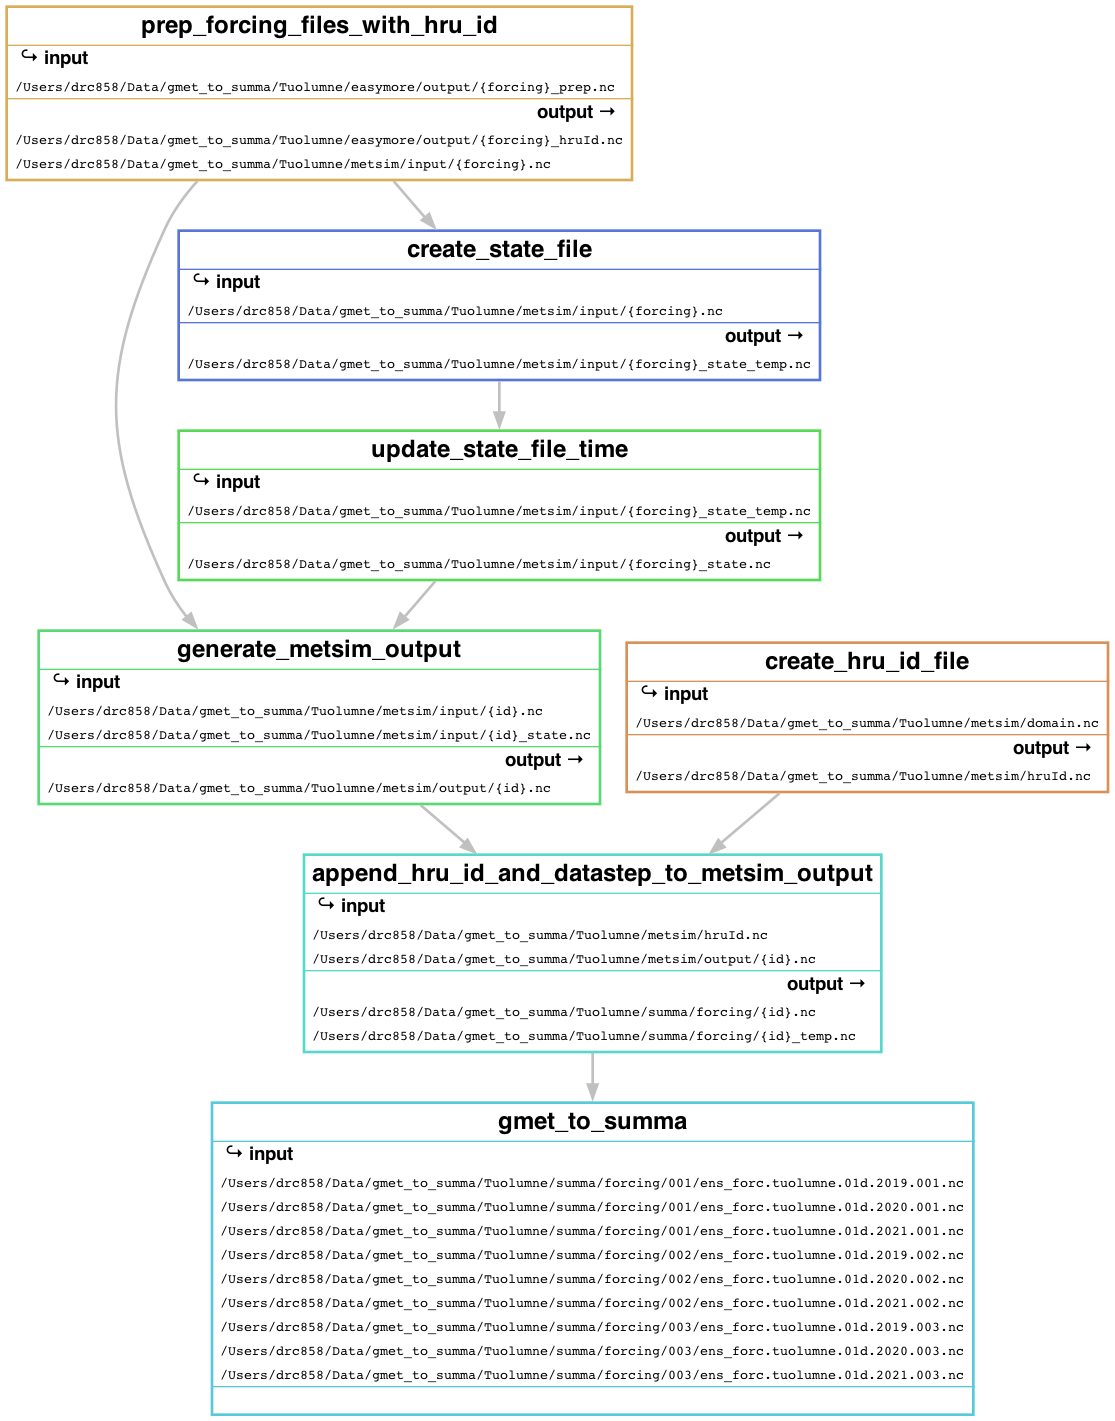

In [108]:
# Snake Command line to build the image
! snakemake -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml --filegraph | dot -Tpng > ../reports/gmet_to_summa.png
# Python command to visualise the built image in our notebook
display.Image('../reports/gmet_to_summa.png')